# Graph Deep Learning on Graph to study Fake News

In [61]:
!pip install dgl

In [62]:
!pip install torch_geometric

^C
Traceback (most recent call last):
  File "/home/crvr/Ulm/M1/.venv/bin/pip", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstr

In [1]:
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch.nn.modules import Linear
from torch_geometric.transforms import ToUndirected
from torch.functional import F
import torch
import argparse
import os.path as osp


The dataset is initialized there. Note that:
- `bert` is the result of a transformer on average tweeets of the author and other info from him/her (as in our article)
- `profile` (user profile info such as number of tweets, followers, and join date)
- `dataset` is either `politifact` or `gossipcop`

Hence this is the same datas as our article except that I struggle to understand their "Network and relations" embedding in our original paper: isn't it already in the edges in a message-passing strategy ?

In [2]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import UPFD
import os.path as osp
import torch

_file_ = '..'
file = _file_
dataset = 'gossipcop'  # or 'politifact'
path = osp.join(osp.dirname(osp.realpath(file)), '..', 'data', 'UPFD')

train_dataset_bert = UPFD(path, dataset, 'bert', 'train')
train_dataset_profile = UPFD(path, dataset, 'profile', 'train')
train_dataset_spacy = UPFD(path, dataset, "spacy", 'train')
train_dataset_content = UPFD(path, dataset, "content", "train")

val_dataset_bert = UPFD(path, dataset, 'bert', 'val')
val_dataset_profile = UPFD(path, dataset, 'profile', 'val')
val_dataset_spacy = UPFD(path, dataset, 'spacy', 'val')
val_dataset_content = UPFD(path, dataset, "content", "val")

test_dataset_bert = UPFD(path, dataset, 'bert', 'test')
test_dataset_profile = UPFD(path, dataset, 'profile', 'test')
test_dataset_spacy = UPFD(path, dataset, 'spacy', 'test')
test_dataset_content = UPFD(path, dataset, "content", "test")


def combine_features(*datasets):
    combined_data = []
    for data_list in zip(*datasets):
        combined_data_point = data_list[0].clone() 
        combined_features = torch.cat([data.x for data in data_list], dim=-1)  
        combined_data_point.x = combined_features  
        combined_data.append(combined_data_point)
    return combined_data


def create_dataset_with_profile():
    return train_dataset_profile, val_dataset_profile, test_dataset_profile

def create_random_dataset():
    train_rdm = [data.clone() for data in train_dataset_bert] 
    val_rdm = [data.clone() for data in val_dataset_bert]
    test_rdm = [data.clone() for data in test_dataset_bert]

    for e in train_rdm:
        e.x = torch.rand_like(e.x)
    for e in val_rdm:
        e.x = torch.rand_like(e.x)
    for e in test_rdm:
        e.x = torch.rand_like(e.x)

    return train_rdm, val_rdm, test_rdm


def create_dataset_with_profile_and_content():
    train_combined = combine_features(train_dataset_profile, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_content)
    return train_combined, val_combined, test_combined


def create_dataset_with_profile_bert_spacy():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy)
    return train_combined, val_combined, test_combined


def create_dataset_with_all_features():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy, test_dataset_content)
    return train_combined, val_combined, test_combined


train_dataset, val_dataset, test_dataset = create_dataset_with_all_features()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Debugging: Print the length of features for the first graph
print(f"Number of total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"Length for the model: {len(train_dataset[0].x[0])}")


Number of total samples: 5464
Length for the model: 1388


/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [15]:
import torch
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_roc_auc_with_ci(model, dataloader, num_bootstrap=1000, confidence_level=0.95, device='cpu'):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            data.x = data.x.to(device)
            logits = model(data.x, data.edge_index, data.batch)
            all_preds.append(logits.cpu())
            all_labels.append(data.y.cpu())

    # Concaténer tous les logits et labels
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calcul des probabilités pour la classe positive (1)
    probs = all_preds.softmax(dim=1)[:, 1].numpy()
    labels = all_labels.numpy()

    # Calcul du ROC AUC original
    original_auc = roc_auc_score(labels, probs)

    # Bootstrap pour la CI
    bootstrapped_aucs = []
    n_samples = len(labels)
    rng = np.random.default_rng()

    for _ in range(num_bootstrap):
        indices = rng.integers(0, n_samples, n_samples)
        boot_probs = probs[indices]
        boot_labels = labels[indices]

        # Vérifier qu'il y a au moins deux classes
        if len(np.unique(boot_labels)) < 2:
            continue

        auc = roc_auc_score(boot_labels, boot_probs)
        bootstrapped_aucs.append(auc)

    lower_percentile = ((1 - confidence_level) / 2) * 100
    upper_percentile = (confidence_level + (1 - confidence_level) / 2) * 100

    lower_bound = np.percentile(bootstrapped_aucs, lower_percentile)
    upper_bound = np.percentile(bootstrapped_aucs, upper_percentile)

    return original_auc, lower_bound, upper_bound
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def plot_roc_with_ci(model, dataloader, num_bootstrap=1000, confidence_level=0.95, device='cpu'):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            data.x = data.x.to(device)
            logits = model(data.x, data.edge_index, data.batch)
            all_preds.append(logits.cpu())
            all_labels.append(data.y.cpu())

    # Concaténer tous les logits et labels
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calcul des probabilités pour la classe positive (1)
    probs = all_preds.softmax(dim=1)[:, 1].numpy()
    labels = all_labels.numpy()

    # Calcul du ROC AUC original et des points de la courbe ROC
    fpr, tpr, _ = roc_curve(labels, probs)
    original_auc = auc(fpr, tpr)

    # Bootstrap pour la CI
    bootstrapped_aucs = []
    boot_fprs = []
    boot_tprs = []
    n_samples = len(labels)
    rng = np.random.default_rng()

    for _ in range(num_bootstrap):
        indices = rng.integers(0, n_samples, n_samples)
        boot_probs = probs[indices]
        boot_labels = labels[indices]

        # Vérifier qu'il y a au moins deux classes
        if len(np.unique(boot_labels)) < 2:
            continue

        boot_fpr, boot_tpr, _ = roc_curve(boot_labels, boot_probs)
        boot_fprs.append(boot_fpr)
        boot_tprs.append(boot_tpr)
        bootstrapped_aucs.append(auc(boot_fpr, boot_tpr))

    lower_percentile = ((1 - confidence_level) / 2) * 100
    upper_percentile = (confidence_level + (1 - confidence_level) / 2) * 100

    lower_bound = np.percentile(bootstrapped_aucs, lower_percentile)
    upper_bound = np.percentile(bootstrapped_aucs, upper_percentile)

    # Affichage de la courbe ROC
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {original_auc:.2f})')

    # Moyenne des courbes bootstrap
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, boot_fpr, boot_tpr) for boot_fpr, boot_tpr in zip(boot_fprs, boot_tprs)], axis=0)
    # Intervalle de confiance sur les AUC
    plt.fill_between(mean_fpr, 
                     np.percentile([np.interp(mean_fpr, boot_fpr, boot_tpr) for boot_fpr, boot_tpr in zip(boot_fprs, boot_tprs)], lower_percentile, axis=0),
                     np.percentile([np.interp(mean_fpr, boot_fpr, boot_tpr) for boot_fpr, boot_tpr in zip(boot_fprs, boot_tprs)], upper_percentile, axis=0),
                     color='grey', alpha=0.2, label=f'{confidence_level*100:.1f}% CI')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Confidence Interval')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    return original_auc, lower_bound, upper_bound


In [5]:
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"

In [6]:
print(train_dataset_bert)
print(train_dataset[0].y)
print(train_dataset[0].x)
print(train_dataset[0].edge_index)
#train_dataset[i] représente l'arbre i
#Le champ x représente la valeur des noeud, il est de taille (n, 778).
#Le champ edge index représente les connexion dans l'abre. Il est de taille (2, n - 1). edge_index[0][i] est
#le père de edge_index[1][i]. En pratique, il se trouve que edge_index[1][i] est toujours un linespace, ce qui est possible
#Le champ y représente si c'est un graphe de fake news ou pas

UPFD(1092, name=gossipcop, feature=bert)
tensor([0])
tensor([[0.0000e+00, 0.0000e+00, 5.9720e-03,  ..., 6.7935e-01, 1.1746e-01,
         1.5336e-01],
        [0.0000e+00, 1.0000e+00, 6.4204e-05,  ..., 8.9041e-02, 1.1111e-01,
         1.3235e-01],
        [0.0000e+00, 1.0000e+00, 1.6861e-05,  ..., 4.6575e-01, 1.6667e-01,
         1.7647e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 1.4283e-06,  ..., 8.9041e-01, 1.1111e-01,
         5.8824e-02],
        [0.0000e+00, 1.0000e+00, 4.4859e-04,  ..., 6.2329e-01, 2.2222e-01,
         3.5294e-01],
        [0.0000e+00, 0.0000e+00, 8.6395e-06,  ..., 7.7397e-01, 1.1111e-01,
         2.5000e-01]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1, 70, 74],
     

### Model

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
"""
@torch.no_grad()
def plot_roc_curve(loader, model):
    model.eval()

    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        all_preds.append(logits.cpu())
        all_labels.append(data.y.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=all_preds.size(1)).float()
    for class_idx in range(all_preds.size(1)):
        if class_idx ==1: break
        fpr, tpr, _ = roc_curve(one_hot_labels[:, class_idx], all_preds[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()
"""

"\n@torch.no_grad()\ndef plot_roc_curve(loader, model):\n    model.eval()\n\n    all_preds = []\n    all_labels = []\n    \n    for data in loader:\n        data = data.to(device)\n        logits = model(data.x, data.edge_index, data.batch)\n        all_preds.append(logits.cpu())\n        all_labels.append(data.y.cpu())\n    \n    all_preds = torch.cat(all_preds, dim=0)\n    all_labels = torch.cat(all_labels, dim=0)\n    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=all_preds.size(1)).float()\n    for class_idx in range(all_preds.size(1)):\n        if class_idx ==1: break\n        fpr, tpr, _ = roc_curve(one_hot_labels[:, class_idx], all_preds[:, class_idx])\n        roc_auc = auc(fpr, tpr)\n        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')\n    plt.xlim([0.0, 1.0])\n    plt.ylim([0.0, 1.05])\n    plt.xlabel('False Positive Rate')\n    plt.ylabel('True Positive Rate')\n    plt.title('ROC Curve')\n    plt.legend(loc='lower right')\n    p

In [8]:
class Net(torch.nn.Module):
    """
    This is the same model as the article. They do not specify the dimensions of hidden channels so this is our choice.
    They do not specify the convolution method,  GCN seems to be the best.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, concat=False):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels).to(device)
        self.conv2 = GCNConv(hidden_channels, hidden_channels).to(device)
        #self.conv1 = GATConv(in_channels, hidden_channels)
        #self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.mean_pooling = global_mean_pool
        self.lin1 = Linear(hidden_channels, 2 * hidden_channels).to(device)
        self.lin2 = Linear(2*hidden_channels,2).to(device)

    def forward(self, x, edge_index, batch):
        x = x.to(device)
        x = self.conv1(x, edge_index).to(device)
        x = torch.nn.functional.selu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.mean_pooling(x, batch)
        x = torch.nn.functional.selu(x)
        x = self.lin1(x)
        x = torch.nn.functional.selu(x)
        x = self.lin2(x)
        return x.softmax(dim=-1)

In [9]:
loss_fn = torch.nn.HingeEmbeddingLoss() # They specify that they want  the HingeEmbeddingLoss so we used it. 
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        y = torch.tensor([[1,0] if e==1 else [0,1] for e in data.y]).to(device)
        loss = loss_fn(out,y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader, model):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred ==
         data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

### Ablation Study

In [86]:
# Only BERT
train_dataset,val_dataset,test_dataset = train_dataset_bert, val_dataset_bert, test_dataset_bert
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
modelBert = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelBert.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [87]:
for epoch in range(1, 200):
    loss = train(modelBert)
    train_acc = test(train_loader, modelBert)
    val_acc = test(val_loader, modelBert)
    test_acc = test(test_loader, modelBert)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7600, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 02, Loss: 0.7386, Train: 0.5119, Val: 0.4853, Test: 0.5024
Epoch: 03, Loss: 0.7110, Train: 0.6777, Val: 0.6593, Test: 0.6722
Epoch: 04, Loss: 0.6682, Train: 0.7427, Val: 0.7381, Test: 0.7248
Epoch: 05, Loss: 0.6430, Train: 0.7445, Val: 0.7436, Test: 0.7128
Epoch: 06, Loss: 0.6366, Train: 0.7518, Val: 0.7399, Test: 0.7201
Epoch: 07, Loss: 0.6222, Train: 0.7555, Val: 0.7418, Test: 0.7253
Epoch: 08, Loss: 0.6177, Train: 0.7848, Val: 0.7637, Test: 0.7326
Epoch: 09, Loss: 0.6162, Train: 0.7793, Val: 0.7454, Test: 0.7329
Epoch: 10, Loss: 0.6107, Train: 0.7793, Val: 0.7473, Test: 0.7324
Epoch: 11, Loss: 0.6072, Train: 0.8022, Val: 0.7802, Test: 0.7462
Epoch: 12, Loss: 0.6051, Train: 0.7582, Val: 0.7418, Test: 0.7156
Epoch: 13, Loss: 0.6166, Train: 0.8049, Val: 0.7711, Test: 0.7507
Epoch: 14, Loss: 0.6135, Train: 0.8123, Val: 0.7674, Test: 0.7527
Epoch: 15, Loss: 0.6010, Train: 0.7647, Val: 0.7161, Test: 0.7206
Epoch: 16,

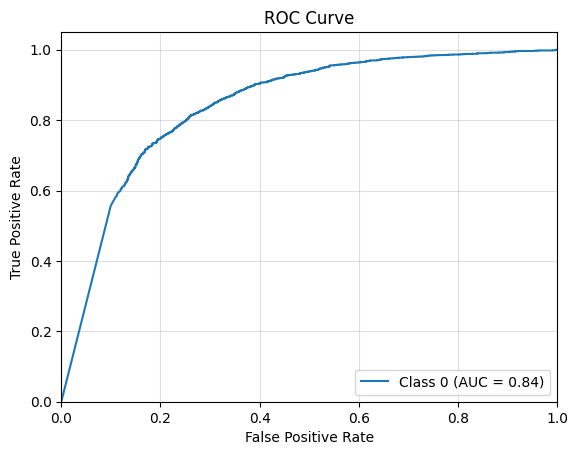

(np.float64(0.8361574888784444),
 np.float64(0.8239206491302993),
 np.float64(0.8475129719344197))

In [88]:
plot_roc_curve(test_loader,modelBert)
calculate_roc_auc_with_ci(modelBert,test_loader)

In [95]:
# Only BERT
train_dataset,val_dataset,test_dataset = train_dataset_spacy, val_dataset_spacy, test_dataset_spacy
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = "cpu"#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelSpacy = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelSpacy.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [96]:
for epoch in range(1, 200):
    loss = train(modelSpacy)
    train_acc = test(train_loader, modelSpacy)
    val_acc = test(val_loader, modelSpacy)
    test_acc = test(test_loader, modelSpacy)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7460, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7323, Train: 0.6685, Val: 0.6648, Test: 0.6715
Epoch: 03, Loss: 0.7040, Train: 0.7216, Val: 0.7253, Test: 0.7101
Epoch: 04, Loss: 0.6714, Train: 0.7271, Val: 0.7198, Test: 0.7164
Epoch: 05, Loss: 0.6447, Train: 0.7445, Val: 0.7656, Test: 0.7371
Epoch: 06, Loss: 0.6337, Train: 0.7463, Val: 0.7436, Test: 0.7316
Epoch: 07, Loss: 0.6255, Train: 0.7738, Val: 0.7766, Test: 0.7501
Epoch: 08, Loss: 0.6170, Train: 0.7701, Val: 0.7985, Test: 0.7538
Epoch: 09, Loss: 0.6125, Train: 0.8068, Val: 0.8059, Test: 0.7624
Epoch: 10, Loss: 0.6042, Train: 0.8040, Val: 0.8187, Test: 0.7716
Epoch: 11, Loss: 0.6013, Train: 0.8141, Val: 0.8242, Test: 0.7744
Epoch: 12, Loss: 0.5974, Train: 0.8205, Val: 0.8168, Test: 0.7757
Epoch: 13, Loss: 0.5972, Train: 0.8260, Val: 0.8242, Test: 0.7763
Epoch: 14, Loss: 0.5917, Train: 0.8342, Val: 0.8315, Test: 0.7818
Epoch: 15, Loss: 0.5859, Train: 0.8434, Val: 0.8242, Test: 0.7823
Epoch: 16,

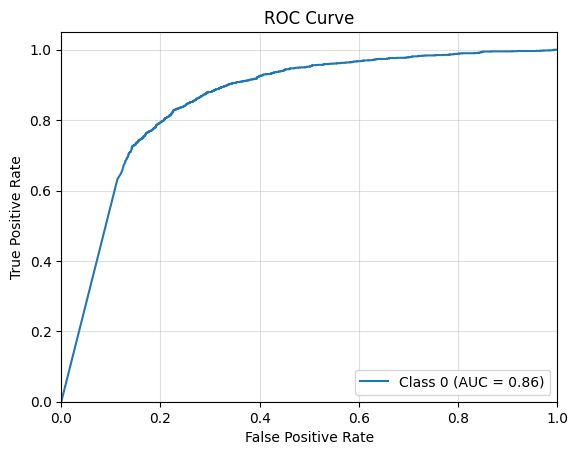

(np.float64(0.8553658090043612),
 np.float64(0.8446858791352929),
 np.float64(0.8671407602662575))

In [97]:
plot_roc_curve(test_loader,modelSpacy)
calculate_roc_auc_with_ci(modelSpacy,test_loader)

In [100]:
# Only content
train_dataset,val_dataset,test_dataset = train_dataset_content, val_dataset_content, test_dataset_content
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
###device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelContent = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelContent.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [101]:
for epoch in range(1, 200):
    loss = train(modelContent)
    train_acc = test(train_loader, modelContent)
    val_acc = test(val_loader, modelContent)
    test_acc = test(test_loader, modelContent)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7421, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7258, Train: 0.8892, Val: 0.9066, Test: 0.8714
Epoch: 03, Loss: 0.7027, Train: 0.6813, Val: 0.6667, Test: 0.6817
Epoch: 04, Loss: 0.6784, Train: 0.6987, Val: 0.6941, Test: 0.6971
Epoch: 05, Loss: 0.6484, Train: 0.8690, Val: 0.8736, Test: 0.8528
Epoch: 06, Loss: 0.6117, Train: 0.6758, Val: 0.6538, Test: 0.6754
Epoch: 07, Loss: 0.5974, Train: 0.9057, Val: 0.9212, Test: 0.8936
Epoch: 08, Loss: 0.5685, Train: 0.9258, Val: 0.9359, Test: 0.9140
Epoch: 09, Loss: 0.5818, Train: 0.8526, Val: 0.8407, Test: 0.8325
Epoch: 10, Loss: 0.5822, Train: 0.9167, Val: 0.9084, Test: 0.9140
Epoch: 11, Loss: 0.5652, Train: 0.9075, Val: 0.9011, Test: 0.9101
Epoch: 12, Loss: 0.5523, Train: 0.9322, Val: 0.9304, Test: 0.9208
Epoch: 13, Loss: 0.5426, Train: 0.9386, Val: 0.9377, Test: 0.9300
Epoch: 14, Loss: 0.5394, Train: 0.9405, Val: 0.9286, Test: 0.9386
Epoch: 15, Loss: 0.5363, Train: 0.9414, Val: 0.9341, Test: 0.9399
Epoch: 16,

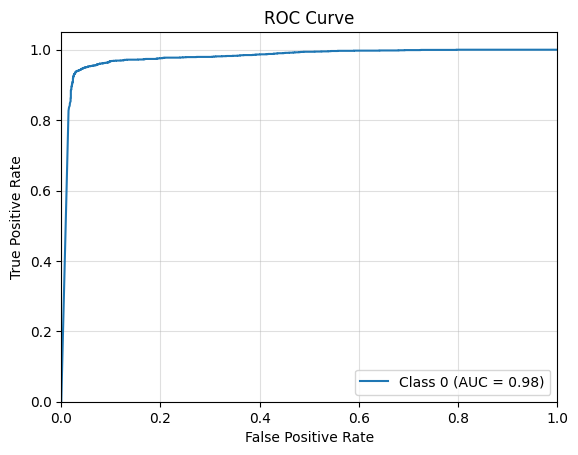

(np.float64(0.9746047339024363),
 np.float64(0.9694433466069352),
 np.float64(0.9797006150560664))

In [102]:
plot_roc_curve(test_loader,modelContent)
calculate_roc_auc_with_ci(modelContent,test_loader)

In [103]:
# Only the user profile
train_dataset,val_dataset,test_dataset = create_dataset_with_profile()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [104]:
for epoch in range(1, 200):
    loss = train(model1)
    train_acc = test(train_loader, model1)
    val_acc = test(val_loader, model1)
    test_acc = test(test_loader, model1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7347, Train: 0.5696, Val: 0.5659, Test: 0.5646
Epoch: 02, Loss: 0.7124, Train: 0.5714, Val: 0.5879, Test: 0.5768
Epoch: 03, Loss: 0.6971, Train: 0.6722, Val: 0.6795, Test: 0.6806
Epoch: 04, Loss: 0.6780, Train: 0.6914, Val: 0.7070, Test: 0.6965
Epoch: 05, Loss: 0.6631, Train: 0.7042, Val: 0.7308, Test: 0.7175
Epoch: 06, Loss: 0.6522, Train: 0.7189, Val: 0.7344, Test: 0.7240
Epoch: 07, Loss: 0.6465, Train: 0.7363, Val: 0.7418, Test: 0.7331
Epoch: 08, Loss: 0.6391, Train: 0.7463, Val: 0.7601, Test: 0.7402
Epoch: 09, Loss: 0.6332, Train: 0.7518, Val: 0.7747, Test: 0.7486
Epoch: 10, Loss: 0.6269, Train: 0.7738, Val: 0.7875, Test: 0.7632
Epoch: 11, Loss: 0.6240, Train: 0.7729, Val: 0.7821, Test: 0.7564
Epoch: 12, Loss: 0.6138, Train: 0.7875, Val: 0.8022, Test: 0.7815
Epoch: 13, Loss: 0.6013, Train: 0.8324, Val: 0.8260, Test: 0.8199
Epoch: 14, Loss: 0.5912, Train: 0.8571, Val: 0.8425, Test: 0.8434
Epoch: 15, Loss: 0.5804, Train: 0.8443, Val: 0.8223, Test: 0.8348
Epoch: 16,

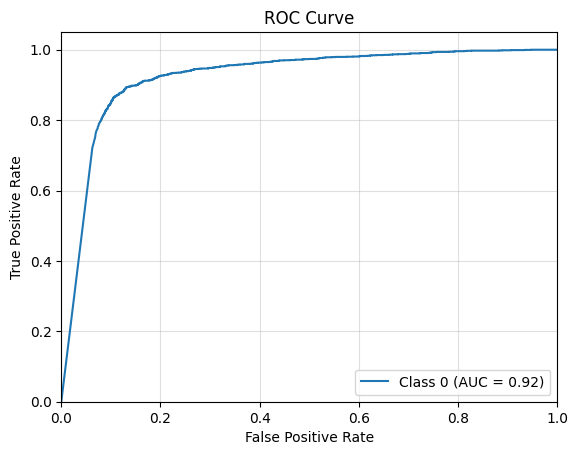

(np.float64(0.9208829750024594),
 np.float64(0.911573674850493),
 np.float64(0.9297305803136969))

In [105]:
plot_roc_curve(test_loader,model1)
calculate_roc_auc_with_ci(model1,test_loader)

In [10]:
# Profile + content
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_and_content()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
for epoch in range(1, 200):
    loss = train(model2)
    train_acc = test(train_loader, model2)
    val_acc = test(val_loader, model2)
    test_acc = test(test_loader, model2)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7480, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7444, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7379, Train: 0.6145, Val: 0.6062, Test: 0.6048
Epoch: 04, Loss: 0.7039, Train: 0.8452, Val: 0.8791, Test: 0.8468
Epoch: 05, Loss: 0.6655, Train: 0.8571, Val: 0.8535, Test: 0.8562
Epoch: 06, Loss: 0.6232, Train: 0.8370, Val: 0.8571, Test: 0.8272
Epoch: 07, Loss: 0.5908, Train: 0.8874, Val: 0.9121, Test: 0.8868
Epoch: 08, Loss: 0.5819, Train: 0.9139, Val: 0.9286, Test: 0.9166
Epoch: 09, Loss: 0.5565, Train: 0.9249, Val: 0.9359, Test: 0.9305
Epoch: 10, Loss: 0.5683, Train: 0.9258, Val: 0.9341, Test: 0.9365
Epoch: 11, Loss: 0.5610, Train: 0.8947, Val: 0.8846, Test: 0.9036
Epoch: 12, Loss: 0.5479, Train: 0.9341, Val: 0.9432, Test: 0.9399
Epoch: 13, Loss: 0.5385, Train: 0.9332, Val: 0.9304, Test: 0.9307
Epoch: 14, Loss: 0.5389, Train: 0.9359, Val: 0.9359, Test: 0.9407
Epoch: 15, Loss: 0.5344, Train: 0.9441, Val: 0.9396, Test: 0.9430
Epoch: 16,

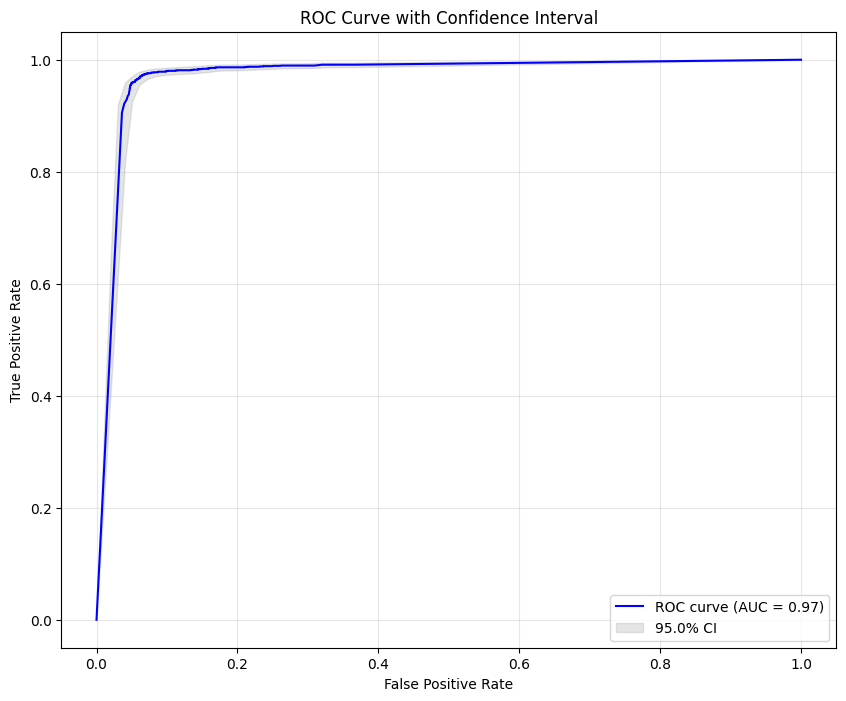

(np.float64(0.971732394058302),
 np.float64(0.9658754838385216),
 np.float64(0.976962336480225))

In [16]:
plot_roc_with_ci(model2,test_loader)
calculate_roc_auc_with_ci(model2,test_loader)

In [109]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_all_features()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [110]:
for epoch in range(1, 200):
    loss = train(model3)
    train_acc = test(train_loader, model3)
    val_acc = test(val_loader, model3)
    test_acc = test(test_loader, model3)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7444, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7142, Train: 0.5421, Val: 0.5311, Test: 0.5329
Epoch: 03, Loss: 0.6687, Train: 0.6355, Val: 0.6429, Test: 0.6171
Epoch: 04, Loss: 0.6533, Train: 0.6758, Val: 0.6868, Test: 0.6620
Epoch: 05, Loss: 0.6347, Train: 0.7134, Val: 0.7143, Test: 0.7020
Epoch: 06, Loss: 0.6295, Train: 0.7894, Val: 0.7985, Test: 0.7729
Epoch: 07, Loss: 0.6179, Train: 0.7839, Val: 0.7875, Test: 0.7648
Epoch: 08, Loss: 0.6067, Train: 0.8031, Val: 0.7894, Test: 0.7710
Epoch: 09, Loss: 0.5978, Train: 0.8214, Val: 0.8132, Test: 0.7831
Epoch: 10, Loss: 0.5991, Train: 0.7299, Val: 0.7161, Test: 0.7122
Epoch: 11, Loss: 0.6174, Train: 0.8233, Val: 0.8114, Test: 0.7909
Epoch: 12, Loss: 0.5934, Train: 0.8352, Val: 0.8132, Test: 0.7927
Epoch: 13, Loss: 0.5981, Train: 0.8324, Val: 0.8150, Test: 0.7922
Epoch: 14, Loss: 0.5924, Train: 0.8086, Val: 0.7894, Test: 0.7781
Epoch: 15, Loss: 0.5826, Train: 0.8645, Val: 0.8352, Test: 0.8207
Epoch: 16,

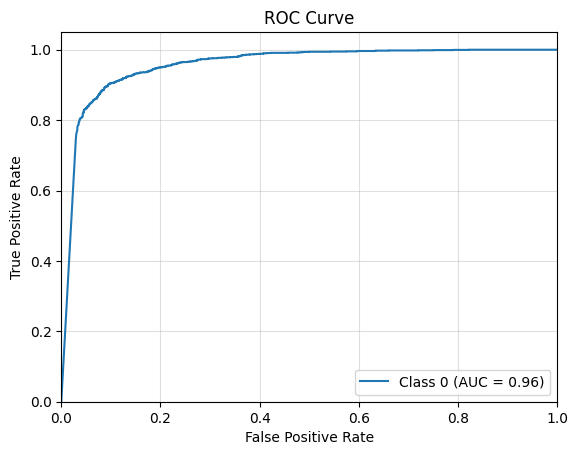

(np.float64(0.9515898086108712),
 np.float64(0.9444587130109782),
 np.float64(0.9580665517043929))

In [111]:
plot_roc_curve(test_loader,model3)
calculate_roc_auc_with_ci(model3,test_loader)

In [112]:
# User profile + user pref
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_bert_spacy()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [113]:
for epoch in range(1, 200):
    loss = train(model4)
    train_acc = test(train_loader, model4)
    val_acc = test(val_loader, model4)
    test_acc = test(test_loader, model4)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7440, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7036, Train: 0.7097, Val: 0.7143, Test: 0.6882
Epoch: 03, Loss: 0.6590, Train: 0.7628, Val: 0.7692, Test: 0.7360
Epoch: 04, Loss: 0.6283, Train: 0.7482, Val: 0.7381, Test: 0.7206
Epoch: 05, Loss: 0.6178, Train: 0.7921, Val: 0.7839, Test: 0.7527
Epoch: 06, Loss: 0.6092, Train: 0.8049, Val: 0.7949, Test: 0.7567
Epoch: 07, Loss: 0.6008, Train: 0.8168, Val: 0.7857, Test: 0.7593
Epoch: 08, Loss: 0.5932, Train: 0.8388, Val: 0.8059, Test: 0.7603
Epoch: 09, Loss: 0.5879, Train: 0.8507, Val: 0.8059, Test: 0.7684
Epoch: 10, Loss: 0.5860, Train: 0.8498, Val: 0.8114, Test: 0.7708
Epoch: 11, Loss: 0.5805, Train: 0.8617, Val: 0.8150, Test: 0.7768
Epoch: 12, Loss: 0.5834, Train: 0.8709, Val: 0.8132, Test: 0.7854
Epoch: 13, Loss: 0.5771, Train: 0.8452, Val: 0.7912, Test: 0.7697
Epoch: 14, Loss: 0.5735, Train: 0.8791, Val: 0.8095, Test: 0.7901
Epoch: 15, Loss: 0.5806, Train: 0.8874, Val: 0.8095, Test: 0.7938
Epoch: 16,

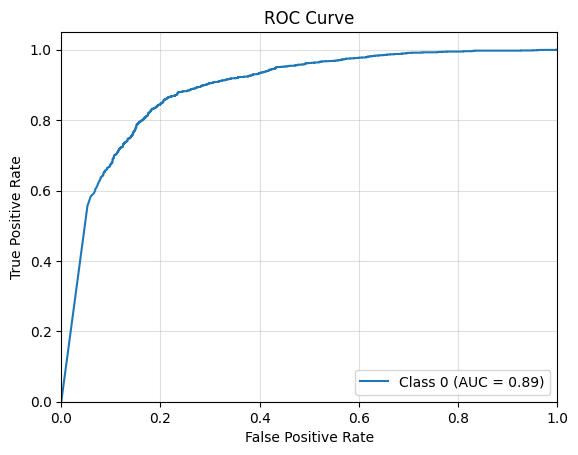

(np.float64(0.8860796106635771),
 np.float64(0.875157434832331),
 np.float64(0.8969399158482757))

In [114]:
plot_roc_curve(test_loader,model4)
calculate_roc_auc_with_ci(model4,test_loader)

In [115]:
# Full random
# Everything
train_dataset,val_dataset,test_dataset = create_random_dataset()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelR = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelR.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.
for epoch in range(1, 200):
    loss = train(modelR)
    train_acc = test(train_loader, modelR)
    val_acc = test(val_loader, modelR)
    test_acc = test(test_loader, modelR)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.7568, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 02, Loss: 0.7549, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 03, Loss: 0.7477, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 05, Loss: 0.7446, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 06, Loss: 0.7405, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 07, Loss: 0.7540, Train: 0.4899, Val: 0.5147, Test: 0.5008
Epoch: 08, Loss: 0.7342, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 09, Loss: 0.7449, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 10, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 11, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 12, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 13, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 14, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 15, Loss: 0.7450, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 16,

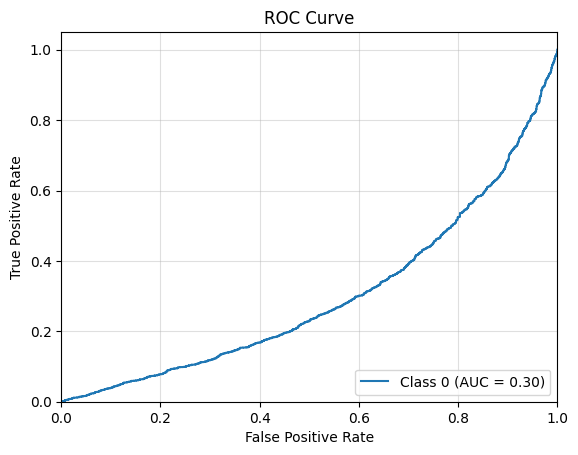

(np.float64(0.5), np.float64(0.5), np.float64(0.5))

In [116]:
plot_roc_curve(test_loader,modelR)
calculate_roc_auc_with_ci(modelR,test_loader)

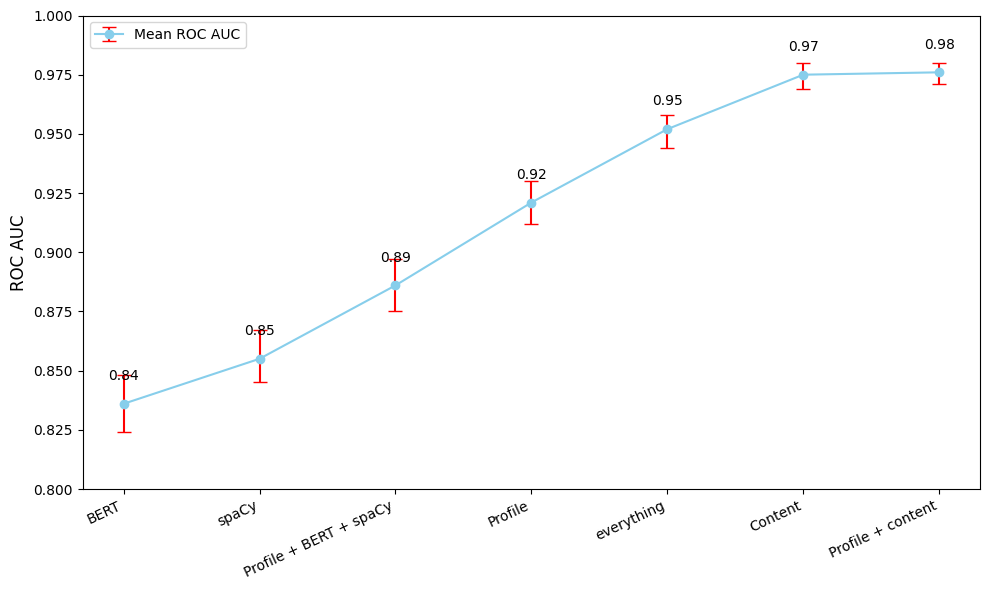

In [126]:
import matplotlib.pyplot as plt

# Données
# Données initiales
labels = [
    "BERT", 
    "spaCy", 
    "Content",
    "Profile", 
    "Profile + content",
    "everything",
    "Profile + BERT + spaCy",
    "Random"
]
auc = [0.836, 0.855, 0.975, 0.921, 0.976, 0.952, 0.886, 0.5]
min_auc = [0.824, 0.845, 0.969, 0.912, 0.971, 0.944, 0.875, 0.5]
max_auc = [0.848, 0.867, 0.980, 0.930, 0.980, 0.958, 0.897, 0.5]

# Tri des données par auc
sorted_data = sorted(zip(auc, min_auc, max_auc, labels))
auc, min_auc, max_auc, labels = zip(*sorted_data)
auc,min_auc,max_auc,labels = auc[1:],min_auc[1:],max_auc[1:],labels[1:]
# Calcul des erreurs
yerr_lower = [a - m for a, m in zip(auc, min_auc)]
yerr_upper = [m - a for a, m in zip(auc, max_auc)]
yerr = [yerr_lower, yerr_upper]

x_indices = range(len(labels))

# Tracé
plt.figure(figsize=(10, 6))
plt.errorbar(x_indices, auc, yerr=yerr, fmt='o', linestyle='-', color='skyblue', ecolor='red', elinewidth=1.5, capsize=5, label="Mean ROC AUC")

# Annotation des points
for i, v in enumerate(auc):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

# Labels et mise en forme
plt.ylabel("ROC AUC", fontsize=12)
plt.ylim(0.8, 1)
plt.xticks(ticks=x_indices, labels=labels, rotation=25, ha='right', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()



### Adding Weight Decay

In [ ]:
# Only BERT
train_dataset,val_dataset,test_dataset = train_dataset_bert, val_dataset_bert, test_dataset_bert
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
modelBert = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelBert.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(modelBert)
    train_acc = test(train_loader, modelBert)
    val_acc = test(val_loader, modelBert)
    test_acc = test(test_loader, modelBert)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7458, Train: 0.5696, Val: 0.5659, Test: 0.5651
Epoch: 02, Loss: 0.7328, Train: 0.5696, Val: 0.5659, Test: 0.5653
Epoch: 03, Loss: 0.7237, Train: 0.5668, Val: 0.5733, Test: 0.5685
Epoch: 04, Loss: 0.7166, Train: 0.5742, Val: 0.5897, Test: 0.5813
Epoch: 05, Loss: 0.7098, Train: 0.6209, Val: 0.6410, Test: 0.6234
Epoch: 06, Loss: 0.7021, Train: 0.6429, Val: 0.6648, Test: 0.6479
Epoch: 07, Loss: 0.6936, Train: 0.6868, Val: 0.7106, Test: 0.6918
Epoch: 08, Loss: 0.6848, Train: 0.7005, Val: 0.7179, Test: 0.7033
Epoch: 09, Loss: 0.6759, Train: 0.7152, Val: 0.7234, Test: 0.7162
Epoch: 10, Loss: 0.6683, Train: 0.7207, Val: 0.7363, Test: 0.7211
Epoch: 11, Loss: 0.6630, Train: 0.7234, Val: 0.7436, Test: 0.7253
Epoch: 12, Loss: 0.6613, Train: 0.7308, Val: 0.7418, Test: 0.7245
Epoch: 13, Loss: 0.6580, Train: 0.7299, Val: 0.7418, Test: 0.7290
Epoch: 14, Loss: 0.6566, Train: 0.7308, Val: 0.7454, Test: 0.7284
Epoch: 15, Loss: 0.6530, Train: 0.7408, Val: 0.7564, Test: 0.7368
Epoch: 16,

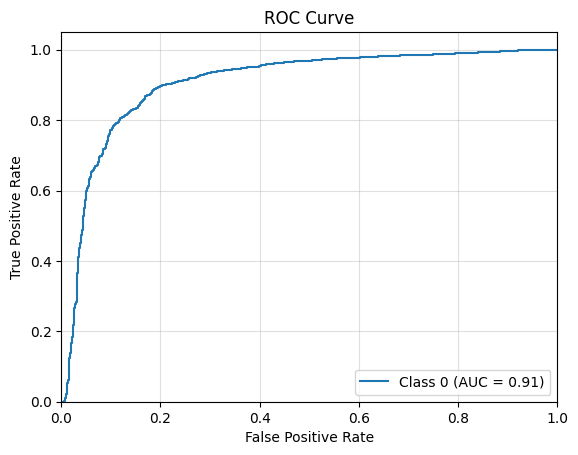

In [ ]:
plot_roc_with_ci(modelBert,test_loader)
calculate_roc_auc_with_ci(modelBert,test_loader)

In [ ]:
# Only spaCy
train_dataset,val_dataset,test_dataset = train_dataset_spacy, val_dataset_spacy, test_dataset_spacy
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = "cpu"#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelSpacy = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelSpacy.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(modelSpacy)
    train_acc = test(train_loader, modelSpacy)
    val_acc = test(val_loader, modelSpacy)
    test_acc = test(test_loader, modelSpacy)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7499, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7419, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7391, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7277, Train: 0.5852, Val: 0.5659, Test: 0.5815
Epoch: 05, Loss: 0.7105, Train: 0.5540, Val: 0.5256, Test: 0.5478
Epoch: 06, Loss: 0.6858, Train: 0.8645, Val: 0.8846, Test: 0.8643
Epoch: 07, Loss: 0.6568, Train: 0.8599, Val: 0.8571, Test: 0.8602
Epoch: 08, Loss: 0.6378, Train: 0.8544, Val: 0.8516, Test: 0.8542
Epoch: 09, Loss: 0.6108, Train: 0.8819, Val: 0.9066, Test: 0.8787
Epoch: 10, Loss: 0.5984, Train: 0.8068, Val: 0.8077, Test: 0.7862
Epoch: 11, Loss: 0.5862, Train: 0.8929, Val: 0.9212, Test: 0.8941
Epoch: 12, Loss: 0.5698, Train: 0.9148, Val: 0.9359, Test: 0.9143
Epoch: 13, Loss: 0.5694, Train: 0.8874, Val: 0.8956, Test: 0.8800
Epoch: 14, Loss: 0.5623, Train: 0.9423, Val: 0.9359, Test: 0.9373
Epoch: 15, Loss: 0.5507, Train: 0.9432, Val: 0.9414, Test: 0.9383
Epoch: 16,

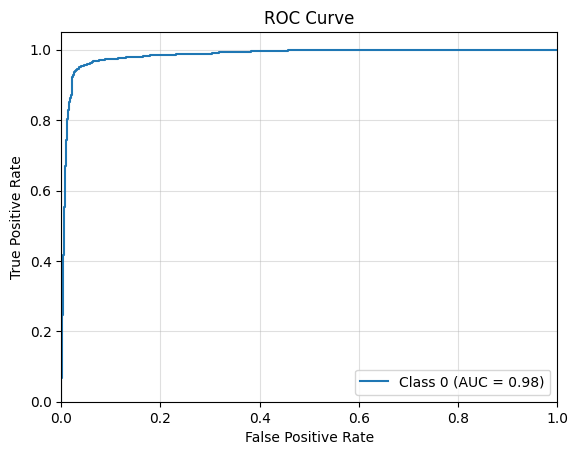

In [ ]:
plot_roc_with_ci(modelSpacy,test_loader)
calculate_roc_auc_with_ci(modelSpacy,test_loader)

In [ ]:
# Only content
train_dataset,val_dataset,test_dataset = train_dataset_content, val_dataset_content, test_dataset_content
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
###device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelContent = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelContent.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(modelContent)
    train_acc = test(train_loader, modelContent)
    val_acc = test(val_loader, modelContent)
    test_acc = test(test_loader, modelContent)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7468, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7439, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7400, Train: 0.5604, Val: 0.5385, Test: 0.5546
Epoch: 04, Loss: 0.7270, Train: 0.6841, Val: 0.6758, Test: 0.6694
Epoch: 05, Loss: 0.6859, Train: 0.7711, Val: 0.7857, Test: 0.7593
Epoch: 06, Loss: 0.6427, Train: 0.7885, Val: 0.7875, Test: 0.7739
Epoch: 07, Loss: 0.6263, Train: 0.8205, Val: 0.8004, Test: 0.7828
Epoch: 08, Loss: 0.6088, Train: 0.7537, Val: 0.7582, Test: 0.7318
Epoch: 09, Loss: 0.6176, Train: 0.8013, Val: 0.7857, Test: 0.7731
Epoch: 10, Loss: 0.5961, Train: 0.8480, Val: 0.8223, Test: 0.8063
Epoch: 11, Loss: 0.5918, Train: 0.8407, Val: 0.8223, Test: 0.8032
Epoch: 12, Loss: 0.5876, Train: 0.8626, Val: 0.8516, Test: 0.8257
Epoch: 13, Loss: 0.5847, Train: 0.8874, Val: 0.8443, Test: 0.8377
Epoch: 14, Loss: 0.5778, Train: 0.7894, Val: 0.7857, Test: 0.7530
Epoch: 15, Loss: 0.6170, Train: 0.8452, Val: 0.8297, Test: 0.8095
Epoch: 16,

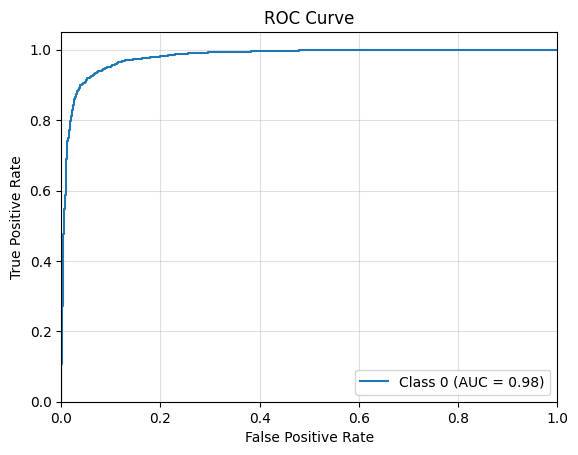

In [ ]:
plot_roc_with_ci(modelContent,test_loader)
calculate_roc_auc_with_ci(modelContent,test_loader)

In [ ]:
# Only the user profile
train_dataset,val_dataset,test_dataset = create_dataset_with_profile()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(model1)
    train_acc = test(train_loader, model1)
    val_acc = test(val_loader, model1)
    test_acc = test(test_loader, model1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7543, Train: 0.6108, Val: 0.5861, Test: 0.6025
Epoch: 02, Loss: 0.7373, Train: 0.5101, Val: 0.4853, Test: 0.4995
Epoch: 03, Loss: 0.7247, Train: 0.5751, Val: 0.5696, Test: 0.5549
Epoch: 04, Loss: 0.7097, Train: 0.7106, Val: 0.7143, Test: 0.6958
Epoch: 05, Loss: 0.6741, Train: 0.7344, Val: 0.7436, Test: 0.7337
Epoch: 06, Loss: 0.6460, Train: 0.7546, Val: 0.7637, Test: 0.7467
Epoch: 07, Loss: 0.6322, Train: 0.7509, Val: 0.7363, Test: 0.7232
Epoch: 08, Loss: 0.6314, Train: 0.7848, Val: 0.7711, Test: 0.7405
Epoch: 09, Loss: 0.6181, Train: 0.8022, Val: 0.7894, Test: 0.7582
Epoch: 10, Loss: 0.6130, Train: 0.7976, Val: 0.7821, Test: 0.7601
Epoch: 11, Loss: 0.6099, Train: 0.8114, Val: 0.7967, Test: 0.7656
Epoch: 12, Loss: 0.6052, Train: 0.8196, Val: 0.7802, Test: 0.7595
Epoch: 13, Loss: 0.6090, Train: 0.8223, Val: 0.7912, Test: 0.7726
Epoch: 14, Loss: 0.6025, Train: 0.7848, Val: 0.7509, Test: 0.7378
Epoch: 15, Loss: 0.6076, Train: 0.8260, Val: 0.7949, Test: 0.7731
Epoch: 16,

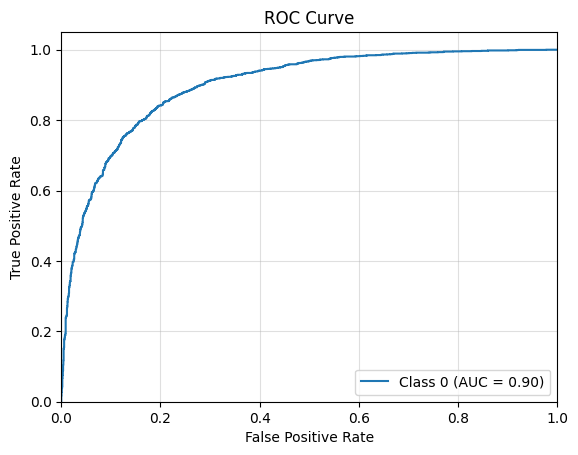

In [ ]:
plot_roc_with_ci(model1,test_loader)
calculate_roc_auc_with_ci(model1,test_loader)

In [ ]:
# Profile + content
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_and_content()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(model2)
    train_acc = test(train_loader, model2)
    val_acc = test(val_loader, model2)
    test_acc = test(test_loader, model2)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
plot_roc_with_ci(model2,test_loader)
calculate_roc_auc_with_ci(model2,test_loader)

In [ ]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_all_features()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(model3)
    train_acc = test(train_loader, model3)
    val_acc = test(val_loader, model3)
    test_acc = test(test_loader, model3)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
plot_roc_with_ci(test_loader,model3)
calculate_roc_auc_with_ci(model3,test_loader)

In [ ]:
# User profile + user pref
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_bert_spacy()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=5e-4,amsgrad=True, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(model4)
    train_acc = test(train_loader, model4)
    val_acc = test(val_loader, model4)
    test_acc = test(test_loader, model4)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
plot_roc_with_ci(test_loader,model4)
calculate_roc_auc_with_ci(model4,test_loader)

In [ ]:
# Full random
# Everything
train_dataset,val_dataset,test_dataset = create_random_dataset()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelR = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(modelR.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(modelR)
    train_acc = test(train_loader, modelR)
    val_acc = test(val_loader, modelR)
    test_acc = test(test_loader, modelR)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [ ]:
plot_roc_with_ci(test_loader,modelR)
calculate_roc_auc_with_ci(modelR,test_loader)